In [240]:
import eurostat
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

code_renewables = 'nrg_inf_epcrw'  # Electricity production capacities for renewables and wastes
code_other = 'nrg_inf_epc'    # Electricity production capacities by main fuel groups and operator
code_pop = 'demo_pjan'

## Loadnig the data

In [241]:
def load_data(code):
    pars = eurostat.get_pars(code)
    
    descriptions = {}
    for par in pars:
        par_values = eurostat.get_par_values(code, par)
        dic = eurostat.get_dic(code, par)
        tempdict = {}
        for flag, description in dic:
            if(flag in par_values):
                tempdict[flag] = description
        descriptions[par] = tempdict
    
    data = eurostat.get_data(code)
    
    return data, descriptions

In [242]:
data_renewables, descriptions_renewables = load_data(code_renewables)
columns = list(data_renewables[0])
columns[4] = 'geo'
data_renewables = pd.DataFrame(data_renewables[1:], columns=columns)

In [243]:
data_other, descriptions_other = load_data(code_other)
columns = list(data_other[0])
columns[5] = 'geo'
data_other = pd.DataFrame(data_other[1:], columns=columns)

In [244]:
data_pop, descriptions_pop = load_data(code_pop)
columns = list(data_pop[0])
columns[4] = 'geo'
data_pop = pd.DataFrame(data_pop[1:], columns=columns)

In [245]:
countries_in_both= set(np.unique(data_other['geo'])) & set(np.unique(data_renewables['geo']))

In [246]:
COUNTRY = data_renewables['geo'] == None
plant_tec = data_renewables['plant_tec'] == 'CAP_NET_ELC'
for geo in countries_in_both:
    COUNTRY = np.logical_or(COUNTRY, data_renewables['geo'] == geo)

condition_renewables = np.logical_and(COUNTRY, plant_tec)

In [247]:
plant_tec =  data_other['plant_tec'] == 'CAP_NET_ELC'
OPERATOR = data_other['operator'] == 'PRR_MAIN'
in_RENEWABLES = data_other['siec'] == None
for siec in np.unique(data_renewables['siec']):
    in_RENEWABLES = np.logical_or(in_RENEWABLES, data_other['siec'] == siec)
    
COUNTRY = data_other['geo'] == None
for geo in countries_in_both:
    COUNTRY = np.logical_or(COUNTRY, data_other['geo'] == geo)

in_RENEWABLES = np.negative(in_RENEWABLES)

condition_other = np.logical_and(plant_tec, in_RENEWABLES)
condition_other = np.logical_and(condition_other, OPERATOR)
condition_other = np.logical_and(condition_other, COUNTRY)

data_combined = pd.concat(
    [data_other.drop('operator', axis=1).loc[condition_other], data_renewables.loc[condition_renewables]]
    ).sort_values(by=['siec', 'geo']).reset_index().drop(['index','freq','plant_tec','unit'], axis=1)

## Making a lookup function

In [248]:
what_is_descriptions = defaultdict(dict)
def what_is_data(descriptions={}, reset=False):
    if reset:
        global what_is_descriptions
        what_is_descriptions = defaultdict(dict)
        return
    for name in descriptions.keys():
        for tip, description in descriptions[name].items():
            what_is_descriptions[name][tip] = description

In [249]:
what_is_data(reset=True)
what_is_data(descriptions_other)
# what_is_data(descriptions_pop)
what_is_data(descriptions_renewables)
def what_is(descriptor, short=False):
    for name, description in what_is_descriptions.items():
        if descriptor in description:
            return f'type: {name} --> {descriptor}: {what_is_descriptions[name][descriptor]}' if not short else f'{what_is_descriptions[name][descriptor]}'
    return f'{descriptor} does not exsist'

In [250]:
countries_only_in_renewables = set(descriptions_renewables['geo'].keys()) - set(descriptions_other['geo'].keys())
countries_only_in_renewables

{'GE', 'IS', 'MD', 'UA', 'UK', 'XK'}

## Imputing missing data from population

# TODO ugotov kako bujse imputirat

In [251]:
AGE = data_pop['age'] == 'TOTAL'
GENDER = data_pop['sex'] == 'T'
is_COUNTRY = data_pop['geo'] == None

for country in descriptions_renewables['geo'].keys():
    if country != 'EA20' and country != 'EU27_2020':
        is_COUNTRY = np.logical_or(is_COUNTRY, data_pop['geo'] == country)
condition = np.logical_and(AGE, GENDER)
condition = np.logical_and(condition, is_COUNTRY)
data_pop_all = data_pop.loc[condition]


data_pop_all = data_pop_all.drop(['freq','unit','age','sex'], axis=1)

In [252]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
imputer = KNNImputer(n_neighbors=2, weights="distance")
# imputer = IterativeImputer(max_iter=10, random_state=0)
# imputer = SimpleImputer(max_iter=10, random_state=0)
a = imputer.fit_transform(np.rot90(data_pop_all.drop(['geo'], axis=1), k=1))
neki = []
a = np.rot90(a, k=3)
for country, pop in zip(data_pop_all['geo'], a):
    neki.append(pop) 

neki = np.array(neki)
data_pop_imputed = {}

data_pop_imputed['geo'] = data_pop_all['geo']
for name, ind in zip(data_pop_all.columns[1:], range(0, len(data_pop_all.columns)-1)):
    data_pop_imputed[name] = neki[:, ind]
data_pop_imputed = pd.DataFrame(data_pop_imputed)

is_COUNTRY = data_pop_imputed['geo'] == 'XK'

# for country in {'BA', 'FR', 'GE', 'MD', 'ME', 'RS', 'UA', 'XK', 'UK'}:
#     is_COUNTRY = np.logical_or(is_COUNTRY, data_pop_imputed['geo'] == country)

for year in data_pop_imputed.keys()[1:]:
    if year not in data_renewables.keys():
        data_pop_imputed = data_pop_imputed.drop(str(year), axis=1)

data_pop_imputed[is_COUNTRY]

,geo,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
176,XK,2.000322e+06,1.999806e+06,1.999709e+06,1.999587e+06,1.999449e+06,1.999275e+06,1.999039e+06,1.998735e+06,1.998388e+06,1.998109e+06,1.998217e+06,1.997512e+06,1.995456e+06,1985000.0,2016000.0,2041000.0,2100000.0,2126708.0,2153139.0,2180686.0,2208107.0,1794180.0,1.913259e+06,1.948402e+06,1.783113e+06,1.775939e+06,1771604.0,1783531.0,1798506.0,1795666.0,1782115.0,1798186.0,1773971.0


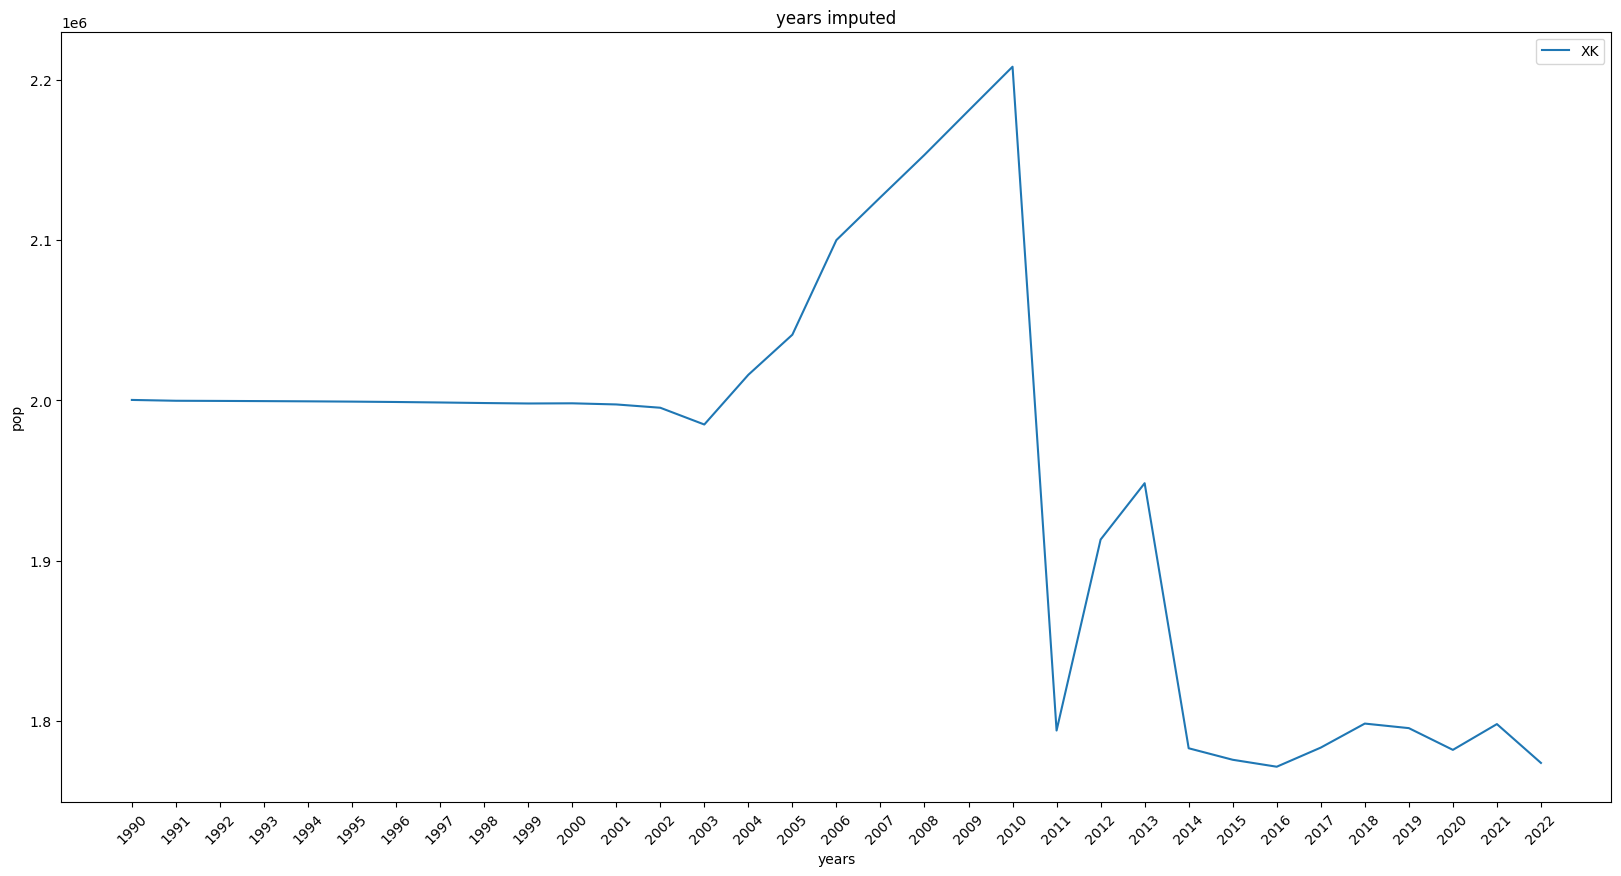

In [253]:
years = data_pop_imputed[is_COUNTRY].columns.tolist()[1:]

# vosta_energij_po_vrsti.plot(x='1990', y='1992')
# fig2 = {'R5100', 'X9900', 'RA500', 'RA200'}
#         CF         N9000      R5100    RA100      RA200    RA300     RA400      RA500    X9900
# colors= ['#232023', '#39FF14', 'green', '#007fff', 'cyan', '#787276', '#a91b0d', 'navy', '#FF00FF']

plt.figure(figsize=(20, 10))
for row in data_pop_imputed[is_COUNTRY].values:
    plt.plot(years, row[1:], label=row[0])

# plt.subplot(1, 2, 1)
plt.ylabel('pop')
plt.xlabel('years')
plt.xticks(rotation=45)
plt.title('years imputed')
plt.legend();

In [254]:
what_is('RA120')

'type: siec --> RA120: Mixed hydro power'

In [255]:
pd.set_option('display.max_columns', 100) #default 20

In [256]:
not_in_energy = []
for geo in data_pop_all['geo']:
    if  what_is(geo)[-6:] == 'exsist':
        not_in_energy.append(geo)

In [257]:
for name in not_in_energy:
    data_pop_all = data_pop_all.drop(data_pop_all[data_pop_all['geo'] == name].index)

In [497]:

import numpy as np
is_PRODUCING = data_other['operator'] == 'PRR_MAIN'
is_SI = data_other['geo'] == 'DE'
is_ACTIVE =  data_other['plant_tec'] == 'CAP_NET_ELC'
condition = np.logical_and(is_PRODUCING, is_ACTIVE)
condition = np.logical_and(condition, is_SI)
data_other.loc[condition].drop([str(year) for year in range(1990, 2022)], axis=1)

,freq,siec,plant_tec,operator,unit,geo,2022
44,A,CF,CAP_NET_ELC,PRR_MAIN,MW,DE,89170.0
266,A,N9000,CAP_NET_ELC,PRR_MAIN,MW,DE,4205.0
488,A,RA100,CAP_NET_ELC,PRR_MAIN,MW,DE,10939.0
562,A,RA110,CAP_NET_ELC,PRR_MAIN,MW,DE,4452.0
784,A,RA120,CAP_NET_ELC,PRR_MAIN,MW,DE,1134.0
1006,A,RA130,CAP_NET_ELC,PRR_MAIN,MW,DE,5353.0
1228,A,RA200,CAP_NET_ELC,PRR_MAIN,MW,DE,50.0
1450,A,RA300,CAP_NET_ELC,PRR_MAIN,MW,DE,66163.0
1524,A,RA310,CAP_NET_ELC,PRR_MAIN,MW,DE,58014.0
1746,A,RA320,CAP_NET_ELC,PRR_MAIN,MW,DE,8149.0


In [259]:
# my_filter_pars = {'geo': ['SI'] , 'siec' : [ 'RA100', 'RA110','RA110ROR', 'RA120', 'RA130']}
# my_filter_pars = {'geo': ['SI'] , 'siec' : [ 'RA100', 'RA110', 'RA120', 'RA130']}
# data = eurostat.get_data(code, filter_pars=my_filter_pars)
# data[1:]

In [260]:


# my_filter_pars = {'geo': ['SI'] , 'siec' : [ 'RA100', 'RA110','RA110ROR', 'RA120', 'RA130']}
# my_filter_pars = {'geo': ['SI'] , 'siec' : [ 'RA100', 'RA110', 'RA120', 'RA130']}
# data = eurostat.get_data(code_renewables, filter_pars=my_filter_pars)

In [261]:
siec_not_to_include = {'RA110','RA120','RA130','RA310','RA320','RA410','RA420','RA420AC',
                       'RA420DC','R5210P','R5220P','R5290','R5300','RA110ROR','RA420KW20-1000',
                       'RA420KW30-1000','RA420KW30-1000_OG','RA420KW30-1000_RT','RA420KW_LT10',
                       'RA420KW_LT20','RA420KW_LT30','RA420KW_LT30_OG','RA420KW_LT30_RT','RA420MW_GT1',
                       'RA420MW_GT1_OG','RA420MW_GT1_RT','RA420OG','W6000','W6100','W6200','TOTAL'}

1. Za vsak tip proizvodnje energije katera država najbolj proizvaja omenjeno energijo

In [505]:
SIEC = data_combined['siec'] == None
for siec in siec_not_to_include:
    SIEC = np.logical_or(SIEC, data_combined['siec'] == siec)
SIEC = np.negative(SIEC)
GEO = np.logical_and(data_combined['geo'] != 'EA20', data_combined['geo'] != 'EU27_2020')
condition = np.logical_and(SIEC, GEO)

In [506]:
data_combined_2022 = data_combined.loc[condition].drop([str(year) for year in range(1990, 2022)], axis=1).reset_index().drop('index', axis=1)

In [584]:
data_pop_2022 = data_pop_imputed.drop([str(year) for year in range(1990, 2022)], axis=1)
GEO = data_pop_2022['geo'] == None
for country in np.unique(data_combined_2022['geo']):
    GEO = np.logical_or(GEO, data_pop_2022['geo'] == country)
data_pop_2022 = data_pop_2022.loc[GEO].reset_index().drop('index', axis=1)

In [585]:
a = pd.DataFrame(data_pop_2022['2022'].to_numpy().reshape(1, 35))
asd = a.reindex(['2022'], columns=np.unique(data_pop_2022['geo']))

In [586]:
for bCol, aCol in zip(asd.keys(), a.keys()):
    asd[bCol] = list(a[aCol])
asd

,AL,AT,BA,BE,BG,CY,CZ,DE,DK,EE,EL,ES,FI,FR,HR,HU,IE,IT,LI,LT,LU,LV,ME,MK,MT,NL,NO,PL,PT,RO,RS,SE,SI,SK,TR
2022,2793592.0,8978929.0,3.841156e+06,11617623.0,6838937.0,904705.0,10516707.0,83237124.0,5873420.0,1331796.0,10459782.0,47432893.0,5548241.0,67871925.0,3862305.0,9689010.0,5060004.0,59030133.0,39308.0,2805998.0,645397.0,1875757.0,617683.0,1837114.0,520971.0,17590672.0,5425270.0,36889761.0,10352042.0,19042455.0,6797105.0,10452326.0,2107180.0,5434712.0,84680273.0


In [587]:
a = pd.DataFrame(data_combined_2022['2022'].to_numpy().reshape(9, 35))
b = a.reindex(labels=np.unique(data_combined_2022['siec']), columns=np.unique(data_combined_2022['geo']))

In [588]:
for bCol, aCol in zip(b.keys(), a.keys()):
    b[bCol] = list(a[aCol])
np.sum(b['SI']) * 24 * 1000 / asd['SI']

2022    48.141835
Name: SI, dtype: float64

In [589]:
b

,AL,AT,BA,BE,BG,CY,CZ,DE,DK,EE,EL,ES,FI,FR,HR,HU,IE,IT,LI,LT,LU,LV,ME,MK,MT,NL,NO,PL,PT,RO,RS,SE,SI,SK,TR
CF,98.00,4361.237,2067.74,6278.1,3811.657,1480.436,10193.619,89170.0,6881.817,1668.0,9819.520,33549.351,6293.0,17336.635,1412.1,5644.0,5629.000,50150.355,0.0,1625.0,86.917,1206.522,225.000,1321.600,498.000,17755.967,289.0,29780.418,4524.793,4838.765,4546.525,6268.0,1527.271,1627.0,43841.374
N9000,0.00,0.000,0.00,4845.0,2006.000,0.000,4290.000,4205.0,0.000,0.0,0.000,7117.290,2794.0,61400.000,0.0,2027.0,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000,512.000,0.0,0.000,0.000,1411.300,0.000,6901.0,688.000,2003.0,0.000
R5100,0.00,784.199,9.22,488.6,15.100,0.000,455.000,1592.0,1707.343,200.0,16.370,867.182,2835.0,911.486,101.2,424.0,6.707,701.179,0.0,62.0,36.350,90.367,0.000,0.000,0.000,284.191,27.0,894.193,592.903,161.448,2.400,3274.0,36.000,180.0,616.168
RA100,2493.00,14923.126,2258.49,1430.3,3389.923,0.000,2285.076,10974.0,6.644,8.0,3421.000,20137.093,3171.0,25963.666,2205.7,60.0,529.000,22860.789,0.0,877.0,1330.045,1587.730,696.685,693.424,0.000,37.700,34269.0,2406.849,8188.590,6662.629,3107.471,16399.0,1346.050,2532.0,31571.485
RA200,0.00,0.250,0.00,0.0,0.000,0.000,0.000,50.0,0.000,0.0,0.000,0.000,0.0,16.150,10.0,3.0,0.000,771.790,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,29.100,0.000,0.000,0.0,0.000,0.0,1691.338
RA300,0.00,3579.236,135.00,5303.4,702.085,157.500,339.095,66163.0,7083.818,316.0,4702.330,30113.764,5677.0,20810.575,986.9,324.0,4536.131,11820.508,0.0,946.0,165.935,82.433,118.000,36.800,0.100,8754.844,5062.0,8150.235,5538.139,3015.202,398.000,14279.0,3.328,4.0,11396.164
RA400,100.14,3791.704,101.56,6756.1,1737.184,424.093,2420.481,67479.0,3069.900,520.0,5430.083,25615.274,664.0,17341.293,222.0,4235.0,187.866,24555.248,0.0,572.0,316.634,113.000,2.870,144.000,222.457,19599.808,328.0,12170.392,2646.257,1808.929,22.437,2388.0,626.164,549.0,9425.440
RA500,0.00,0.000,0.00,0.0,0.000,0.000,0.000,0.0,0.000,0.0,0.000,4.796,0.0,212.070,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000
X9900,0.00,8.000,0.00,108.8,0.000,0.000,0.000,442.0,0.000,0.0,0.000,54.095,40.0,1949.773,0.0,0.0,0.000,142.131,0.0,0.0,0.000,0.000,0.000,0.000,0.000,526.000,81.0,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000


In [590]:
what_is('LI')

'type: geo --> LI: Liechtenstein'

In [591]:
for x in b.keys():
    b[x] = b[x].values * 24 * 1000 / np.repeat(asd[x].values, len(b[x]))

In [594]:
np.sum(b['HR']), np.sum(b['SI'])

(30.683646164660736, 48.14183505917862)

In [593]:
b

,AL,AT,BA,BE,BG,CY,CZ,DE,DK,EE,EL,ES,FI,FR,HR,HU,IE,IT,LI,LT,LU,LV,ME,MK,MT,NL,NO,PL,PT,RO,RS,SE,SI,SK,TR
CF,0.841927,11.657258,12.919486,12.969469,13.376314,39.272983,23.262686,25.710643,28.120517,30.058658,22.530917,16.975233,27.221601,6.130359,8.774657,13.980376,26.698793,20.389731,0.0,13.898798,3.232132,15.437249,8.742348,17.265341,22.941776,24.225522,1.278462,19.374754,10.490204,6.098497,16.053393,14.392203,17.395051,7.184925,12.425479
N9000,0.000000,0.000000,0.000000,10.008932,7.039691,0.000000,9.790137,1.212440,0.000000,0.000000,0.000000,3.601192,12.085993,21.711481,0.000000,5.020946,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.698552,0.000000,0.000000,0.000000,1.778720,0.000000,15.845660,7.836065,8.845363,0.000000
R5100,0.000000,2.096105,0.057608,1.009363,0.052991,0.000000,1.038348,0.459026,6.976554,3.604156,0.037561,0.438775,12.263346,0.322308,0.628847,1.050262,0.031812,0.285080,0.0,0.530293,1.351726,1.156231,0.000000,0.000000,0.000000,0.387739,0.119441,0.581750,1.374576,0.203480,0.008474,7.517561,0.410027,0.794890,0.174634
RA100,21.417587,39.888390,14.111315,2.954752,11.896315,0.000000,5.214733,3.164165,0.027149,0.144166,7.849494,10.188926,13.716780,9.180939,13.706012,0.148622,2.509089,9.294557,0.0,7.501074,49.459604,20.314742,27.069613,9.058870,0.000000,0.051436,151.597248,1.565865,18.984289,8.397189,10.972216,37.654394,15.331011,11.181457,8.947959
RA200,0.000000,0.000668,0.000000,0.000000,0.000000,0.000000,0.000000,0.014417,0.000000,0.000000,0.000000,0.000000,0.000000,0.005711,0.062139,0.007431,0.000000,0.313788,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.067465,0.000000,0.000000,0.000000,0.000000,0.000000,0.479357
RA300,0.000000,9.567028,0.843496,10.955907,2.463839,4.178158,0.773843,19.076969,28.945935,5.694566,10.789510,15.236902,24.556972,7.358769,6.132504,0.802559,21.515229,4.805888,0.0,8.091239,6.170528,1.054717,4.584876,0.480754,0.004607,11.944754,22.392987,5.302437,12.839528,3.800185,1.405304,32.786578,0.037905,0.017664,3.229890
RA400,0.860312,10.134939,0.634559,13.956934,6.096330,11.250332,5.523739,19.456415,12.544242,9.370805,12.459341,12.960765,2.872262,6.132006,1.379487,10.490236,0.891063,9.983477,0.0,4.892377,11.774483,1.445816,0.111514,1.881212,10.248110,26.741184,1.450988,7.917899,6.135038,2.279869,0.079223,5.483181,7.131776,2.424415,2.671349
RA500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002427,0.000000,0.074989,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
X9900,0.000000,0.021383,0.000000,0.224762,0.000000,0.000000,0.000000,0.127443,0.000000,0.000000,0.000000,0.027371,0.173028,0.689454,0.000000,0.000000,0.000000,0.057786,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.717653,0.358323,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [570]:
what_is('R5100')

'type: siec --> R5100: Solid biofuels'

In [519]:
(np.sum(b['DE']) * 1000 / 365 * 24) * 24 * 365 

1661.3164097308313

In [482]:
what_is('MW')

'type: unit --> MW: Megawatt'

3. Keri tip energije proizvaja največ elektrike v evropi

In [270]:
####   filtriranje data setov

# # is_PRODUCING = data_renewables['operator'] == 'PRR_MAIN'
# # is_TOTAL = data_renewables['siec'] != 'TOTAL'
# is_ACTIVE = data_renewables['plant_tec'] == 'CAP_NET_ELC'
# is_GEO = np.logical_and(data_renewables['geo'] != 'EA20', data_renewables['geo'] != 'EU27_2020')
# for country in countries_only_in_renewables:
#     is_GEO = np.logical_and(is_GEO, data_renewables['geo'] != country)
# condition = np.logical_and(is_GEO, is_ACTIVE)
# # condition = np.logical_and(condition, is_TOTAL)
# # condition = np.logical_and(condition, is_GEO)
# condition_2 = condition
# # data_renewables.loc[condition]

# is_PRODUCING = data_other['operator'] == 'PRR_MAIN'
# # is_TOTAL = data_other['siec'] != 'TOTAL'
# is_ACTIVE =  data_other['plant_tec'] == 'CAP_NET_ELC'
# is_GEO = np.logical_and(data_other['geo'] != 'EA20', data_other['geo'] != 'EU27_2020')
# condition = np.logical_and(is_PRODUCING, is_ACTIVE)
# # condition = np.logical_and(condition, is_TOTAL)
# condition = np.logical_and(condition, is_GEO)
# condition_1 = condition
# # data_other.loc[condition]

condition_combined = np.logical_and(data_combined['geo'] != 'EA20', data_combined['geo'] != 'EU27_2020')

In [271]:
####  ustvarjanje zdruzenega dataseta

dictNeki = {}
dictNeki['siec'] = []
for year in data_combined.keys()[2:]:
    dictNeki[year] = []

for siec in np.unique(data_combined['siec']):
    if siec in siec_not_to_include:
        continue
    dictNeki['siec'].append(siec)
    con = np.logical_and(data_combined['siec'] == siec, condition_combined)
    for year in data_combined.keys()[2:]:
        dictNeki[year].append(np.sum(data_combined.loc[con][year])) 
    
# for siec in np.unique(data_renewables['siec']):
#     if siec in siec_not_to_include:
#         continue
#     dictNeki['siec'].append(siec)
#     con = np.logical_and(data_renewables['siec'] == siec, condition_2)
#     for year in range(1990, 2023):
#         dictNeki[str(year)].append(np.sum(data_renewables.loc[con][str(year)]))


# for siec in np.unique(data_other['siec']):
#     if siec in siec_not_to_include or siec in dictNeki['siec']:
#         continue
#     dictNeki['siec'].append(siec)
#     con = np.logical_and(data_other['siec'] == siec, condition_1)
#     for year in range(1990, 2023):
#         dictNeki[str(year)].append(np.sum(data_other.loc[con][str(year)]))
    
vsota_energij_po_vrsti = pd.DataFrame(dictNeki)

In [272]:
vsota_energij_po_vrsti = vsota_energij_po_vrsti.sort_values('siec')
vsota_energij_po_vrsti

,siec,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,CF,235565.000,252358.000,255609.000,257903.000,259559.550,267870.350,272918.350,276630.550,280427.550,289130.550,306312.412,308237.633,313232.633,312819.583,320702.492,330497.118,338485.646,344841.034,350068.028,357109.177,370134.056,409099.783,416520.530,414216.652,417478.044,407882.962,400412.277,395786.297,401302.616,393581.872,386574.460,374376.110,375806.719
1,N9000,110267.000,111444.000,113162.000,114559.000,114225.000,116223.000,117837.000,120175.000,123099.000,124657.000,124851.000,124882.000,126297.000,125416.000,124555.000,123142.000,122837.000,121850.000,122152.000,121684.000,120866.000,121424.000,113237.000,113065.000,113578.000,112497.000,112581.000,111550.590,111266.590,109980.590,106034.590,105111.590,100199.590
2,R5100,3028.000,3081.000,3409.000,3515.000,3727.000,3931.595,4169.396,4063.681,4069.777,4528.246,5265.461,5694.041,5963.134,6977.887,7510.942,9391.990,10510.780,10221.852,11005.763,11935.317,12683.326,13302.658,13546.365,13211.156,14101.276,14299.223,14421.788,15148.744,15724.302,15437.135,15419.189,16548.572,17371.606
3,RA100,156948.000,158355.000,161279.000,163557.000,165170.000,171909.723,173322.723,174386.723,174821.723,176664.723,178813.023,179192.797,180374.797,181212.797,183271.923,186238.998,186818.107,188174.200,189622.961,191752.501,194087.561,197077.536,200878.905,205326.253,207060.033,211572.345,214482.437,218188.623,219918.509,220922.125,224874.256,226170.569,227822.465
4,RA200,517.000,590.000,494.000,494.000,498.000,498.000,513.000,557.000,577.000,617.000,622.000,605.000,700.000,738.000,673.000,700.915,719.915,722.915,729.915,803.915,854.915,888.815,945.415,1106.915,1242.915,1461.665,1663.074,1912.105,2143.923,2381.093,2484.193,2552.510,2571.628
5,RA300,443.981,613.859,812.449,1073.599,1476.737,2233.999,3119.721,4237.547,5907.682,8724.645,12329.515,16876.953,22720.631,27367.316,33316.737,39046.480,45929.090,53909.798,60870.284,72067.527,80682.009,89647.530,100111.041,109209.385,120144.961,132580.551,144662.597,156769.235,166314.664,178285.058,190573.922,204292.228,220700.522
6,RA400,11.000,12.000,28.000,36.000,41.000,52.000,67.000,86.000,104.000,128.000,182.072,279.284,360.748,595.459,1301.974,2274.187,3230.924,4974.133,10373.182,16999.366,30616.219,53288.952,71045.230,79715.838,83680.042,87960.179,92360.983,99691.852,109180.973,126284.433,145174.166,172266.387,215586.314
7,RA500,240.000,240.000,240.000,240.000,240.000,240.000,240.000,240.000,240.000,240.000,213.000,215.000,218.000,219.000,218.000,216.000,215.000,215.000,218.000,216.000,216.000,215.022,216.205,223.284,225.804,223.125,225.020,224.066,223.198,218.863,216.561,215.988,216.866
8,X9900,15.000,15.000,19.000,23.000,37.450,46.650,53.650,64.450,64.450,64.450,208.450,142.450,155.450,373.450,194.450,302.450,389.450,370.450,382.450,421.795,445.295,441.295,442.295,439.295,470.295,844.595,860.595,903.969,888.758,1535.416,1203.463,1579.812,3351.799


In [573]:
np.sum(vsota_energij_po_vrsti['2022'])/1000/1000

1.1636275090000001

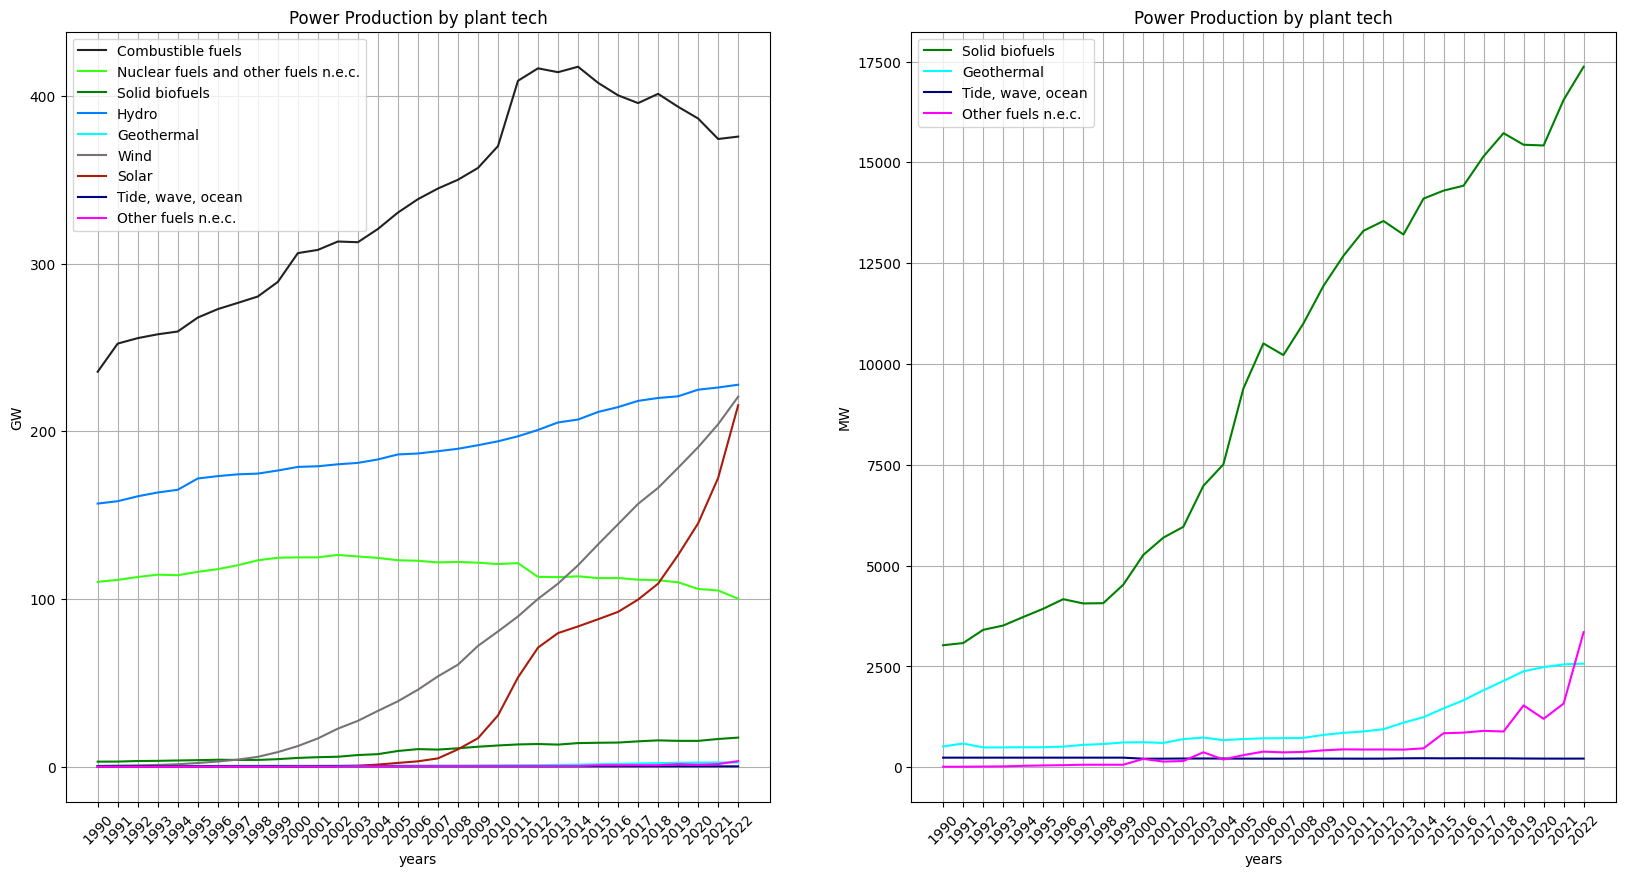

In [268]:
years = vsota_energij_po_vrsti.columns.tolist()[1:]

# vsota_energij_po_vrsti.plot(x='1990', y='1992')
fig2 = {'R5100', 'X9900', 'RA500', 'RA200'}
#         CF         N9000      R5100    RA100      RA200    RA300     RA400      RA500    X9900
colors= ['#232023', '#39FF14', 'green', '#007fff', 'cyan', '#787276', '#a91b0d', 'navy', '#FF00FF']

plt.figure(figsize=(20, 10))
for row, colour in zip(vsota_energij_po_vrsti.values, colors):
    if row[0] in fig2:
        plt.subplot(1, 2, 2)
        plt.plot(years, row[1:], label=what_is(row[0], short=True), color=colour)
    plt.subplot(1, 2, 1)
    plt.plot(years, [power / 1000 for power in row[1:]], label=what_is(row[0], short=True), color=colour)

plt.subplot(1, 2, 1)
plt.ylabel('GW')
plt.xlabel('years')
plt.xticks(rotation=45)
plt.title('Power Production by plant tech')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.ylabel('MW')
plt.xlabel('years')
plt.xticks(rotation=45)
plt.title('Power Production by plant tech')
plt.grid(True)
plt.legend()

plt.show()
